# Overview 

## Objective 
Build a recommendation engine using MovieLens datasets to predict user’s movie interest. 

## Motivation 
Recommendation engines are versatile and being needed/used across many industries - media (news), entertainment (streaming), e-commerce, social media, etc. I want to see how I can build a recommendation engine with movie datasets to do the following:

- Suggest movies based on other user's ratings
- Suggest movies based on movie features
- Predict user’s rating for movies, so that I can suggest movies they might like

## Value 
This exercise will give insight to the business to:
- Predict what users like to make decisions on content
- Create a curated experience for users in the sea of choices

## You can see me using...
- Data Visualization: Seaborn, Matplotlib
- Feature Engineering: PCA, CountVectorizer, one-hot encoding
- Models: NearestNeighbors (Unsupervised), Keras Embedding (Supervised)


## Dataset
https://grouplens.org/datasets/movielens/

## To improve
Originally, I wanted to build a class that recommends movies based on the features that I've built. However, I wasn't able to do that due to tight timeframe. I am planning to improve movie recommendations considering user experience, then build classes in the future.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Dot
from keras.layers import Conv1D
import cv2
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
genomeScores = pd.read_csv('genome-scores.csv')
genomeTags = pd.read_csv('genome-tags.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Get to know the data

In [4]:
print(genomeScores.shape)
genomeScores.head(5)

(11709768, 3)


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


**Tags** - user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

**Timestamps** - seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [5]:
print(movies.shape)
movies.head(5)

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [57]:
print(ratings.shape)
ratings.head(5)

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
print(genomeTags.shape)
genomeTags.head(5)

(1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


Unique columns:
`userId`, `movieId`, `tagId`, `relevance`, `tag`, `timestamp`, `rating`, `title`, `genres`

For the recommendation engine, I will be using following columns:
- `userId`: Unique user ID to predict what they will like, numeric
- `movieId`: Unique movie ID, numeric
- `tagId`: TagID to tell the model feature of the movie, numeric
- `relevance`: important feature fo movie
- `genres`: part of feature, need to transform it to categorical values **
- `year`: need to extract year from the `title` **
- `timestamp`: use the timestamp to divide the train data so that I can introduce the data incrementally

- `rating`: THE TARGET!

# Prepare the data
## Movies Dataset 
### Extract year from the title

In [7]:
movies = pd.read_csv('movies.csv')

In [8]:
get_year='\(([0-9]+)\)'
title=movies['title']

movies['year']=title.apply(lambda x: re.findall(get_year,x))

In [9]:
movies.head(3)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,[1995]
1,2,Jumanji (1995),Adventure|Children|Fantasy,[1995]
2,3,Grumpier Old Men (1995),Comedy|Romance,[1995]


In [10]:
# filter the movies with number in the title
movies[movies['year'].apply(lambda x: len(x)>1)]

,movieId,title,genres,year
872,889,1-900 (06) (1994),Drama|Romance,"[06, 1994]"
13916,69757,(500) Days of Summer (2009),Comedy|Drama|Romance,"[500, 2009]"
20580,100741,Sixtynine (69) (1969),Drama,"[69, 1969]"


In [11]:
movies.at[872,'year']=[1994]
movies.at[13916,'year']=[2009]
movies.at[20580,'year']=[1969]

movies.at[872,'year']

[1994]

In [12]:
# if it's a ongoing show or produced over multiple years, have the starting year as 'year' value

movies.at[22368,'year']=2009
movies.at[22669,'year']=2007
movies.at[22679,'year']=1975

# get rid of brackets and get unique values to validate
movies['year']=movies['year'].str[0]

movies=movies.dropna()
movies.loc[movies.year.isna()].count()

movieId    0
title      0
genres     0
year       0
dtype: int64

In [13]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [14]:
# change year col to int
movies['year']=pd.to_numeric(movies['year'])
movies.dtypes

movieId     int64
title      object
genres     object
year        int64
dtype: object

### Create 'Genres' columns

In [15]:
movies['genres']=movies.genres.str.split('|')

movies['genres'].head(3)

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
Name: genres, dtype: object

In [16]:
genres=movies['genres']

unique_genres=[]

for genre in genres:
    for i in genre:
        if i not in unique_genres:
            unique_genres.append(i)
            
print('There are {} unique genres in the dataset.'.format(len(unique_genres)))

There are 20 unique genres in the dataset.


In [17]:
movies.head(3)

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995


In [18]:
# convert genre lists to feature using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

In [19]:
# convert list to strings
genres = genres.apply(", ".join)

# fit and apply vectorizer
cv=CountVectorizer()
genres_cv = cv.fit_transform(genres)

In [20]:
genres_df = pd.DataFrame(genres_cv.toarray(), columns=cv.get_feature_names())

genres_df.columns

Index(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres', 'horror',
       'imax', 'listed', 'musical', 'mystery', 'no', 'noir', 'romance', 'sci',
       'thriller', 'war', 'western'],
      dtype='object')

We see that the vectorizer divided each word of 'Sci-Fi', 'Film-Noir', and 'No Genres'. We will get rid of redundant columns and rename the remaining ones.

In [21]:
# 'fi', 'film', 'genres', 'listed','no', 'noir', 'sci' 
# -->  'Sci-Fi', 'IMAX', 'Film-Noir', 'No Genres'
      
# validate that they are redundant.
print (genres_df.loc[genres_df.fi==1][['fi','sci']].sum())
print (genres_df.loc[genres_df.noir==1][['film','noir']].sum())
print (genres_df.loc[genres_df.imax==1][['imax']].sum())

fi     1741
sci    1741
dtype: int64
film    330
noir    330
dtype: int64
imax    196
dtype: int64


In [22]:
drop_cols = ['fi', 'film', 'genres', 'listed',]
genres_df=genres_df.drop(drop_cols, axis=1)

#rename remaining columns
genres_df=genres_df.rename(columns={'no':'no_genre', 'noir':'film_noir', 'sci':'sci_fi'})

In [22]:
print(genres_df.shape)
print(movies.shape)
genres_df.tail(3)

(27256, 20)
(27256, 4)


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,imax,musical,mystery,no_genre,film_noir,romance,sci_fi,thriller,war,western
27253,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27254,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
27255,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [23]:
# reset movies table since we dropped some NaN rows.
movies=movies.reset_index(drop=True)

# merge two datasets.
movies=pd.concat([movies, genres_df], axis=1)
movies=movies.drop('genres',axis=1)

In [24]:
movies.tail(3)

,movieId,title,year,action,adventure,animation,children,comedy,crime,documentary,...,imax,musical,mystery,no_genre,film_noir,romance,sci_fi,thriller,war,western
27253,131258,The Pirates (2014),2014,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27254,131260,Rentun Ruusu (2001),2001,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
27255,131262,Innocence (2014),2014,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
from collections import Counter
## Just out of curiosity, I want to see the most common pairs

bigrams = zip(genres, genres[1:])
counts = Counter(bigrams)
print(counts.most_common()[:20])

[(('Drama', 'Drama'), 929), (('Comedy', 'Drama'), 360), (('Drama', 'Comedy'), 354), (('Drama', 'Documentary'), 337), (('Documentary', 'Documentary'), 323), (('Comedy', 'Comedy'), 321), (('Documentary', 'Drama'), 302), (('Comedy, Drama', 'Drama'), 238), (('Drama', 'Comedy, Drama'), 219), (('Drama', 'Drama, Romance'), 198), (('Drama, Romance', 'Drama'), 184), (('Documentary', 'Comedy'), 141), (('Comedy', 'Documentary'), 135), (('Comedy, Romance', 'Drama'), 130), (('Drama', 'Comedy, Romance'), 123), (('Drama', 'Comedy, Drama, Romance'), 112), (('Comedy', 'Comedy, Drama'), 112), (('Comedy, Drama', 'Documentary'), 99), (('Comedy, Drama', 'Comedy'), 99), (('Documentary', 'Comedy, Drama'), 99)]


The most common pairs are:
- Drama + Comedy
- Drama + Documentary
- Drama+ Romance
- Comedy + Documentary
- Comedy + Romance

### Visualization

#### Count of movies made per year

In [25]:
year_desc=movies.year.value_counts()
year_desc=year_desc.sort_index(ascending=False)

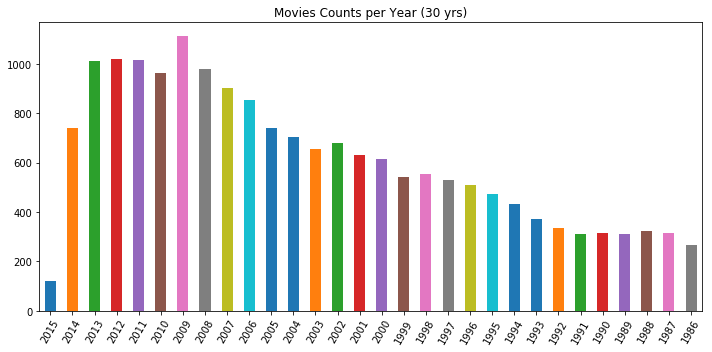

In [26]:
plt.figure(figsize=(10, 5))
year_desc.head(30).plot(kind='bar')
plt.title('Movies Counts per Year (30 yrs)')

plt.xticks(rotation=60)
plt.subplots_adjust(bottom=0.15)
plt.tight_layout(h_pad=1.0)
plt.show()

#### Count of movies per genre

Text(0.5, 1.0, 'Movies Counts per Genre')

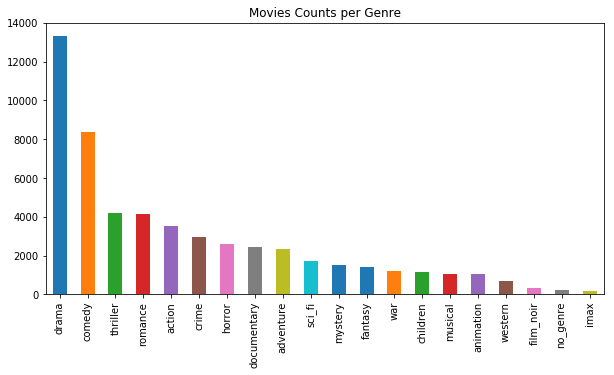

In [28]:
plt.figure(figsize=(10, 5))
genres_df.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Movies Counts per Genre')

#### See if there are correlations among movie genres

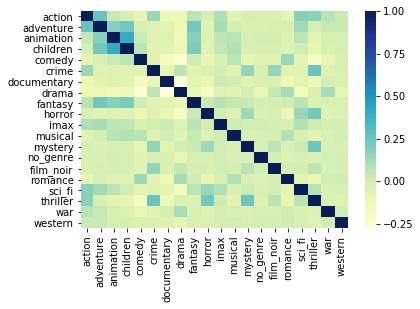

In [32]:
sns.heatmap(genres_df.corr(), cmap="YlGnBu")

## Movie tags

### Explore the tags 

Hypothesis: There are some redundant tags that I can get rid of. I will be validating the hypothesis using corr() function.

In [26]:
print(genomeTags.shape)
genomeTags.head(5)

(1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [26]:
tag_tb=pd.pivot_table(genomeScores, values='relevance', columns='tagId', index='movieId').fillna(0)

In [28]:
tag_tb.head(5)

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,0.03200,...,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,0.02050,...,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,0.02675,...,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
4,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,0.08700,0.05125,0.03025,...,0.05750,0.03375,0.02275,0.03975,0.18525,0.05925,0.01500,0.01525,0.06450,0.01300
5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,0.02875,...,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825


In [27]:
similar_tags=tag_tb.corr().abs()

similar_tags_unstack=similar_tags.unstack()

tags_sort = similar_tags_unstack.sort_values(kind="quicksort")
tags_sort = tags_sort.drop_duplicates()

similar_tags=pd.DataFrame(tags_sort[tags_sort>0.80])

print(similar_tags.sort_values(0,ascending=False).head(10))
print(genomeTags.loc[genomeTags.tagId==1121])
print(genomeTags.loc[genomeTags.tagId==1126])

                    0
tagId tagId          
1     1      1.000000
1069  1067   0.988379
697   696    0.971320
987   989    0.966490
387   388    0.959679
802   803    0.959079
976   657    0.958654
886   890    0.957107
43    45     0.956546
1121  1126   0.955694
      tagId           tag
1120   1121  world war ii
      tagId   tag
1125   1126  wwii


Proved! There are some tags that are redundant. I will be using PCA to reduce dimensions to make my model more robust.

### PCA to reduce dimensionality

In [28]:
from sklearn.decomposition import PCA

pca = PCA().fit(tag_tb)

<Figure size 720x360 with 0 Axes>

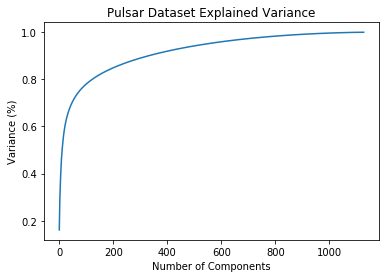

In [31]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 5))
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

Seems like I can explain about 80% of the variance using 100 components. That's a big win considering I am reducing the compenents by more than 90%. 

In [29]:
pca = PCA(n_components=100)
tags_pca = pca.fit_transform(tag_tb)

tags_pca = pd.DataFrame(tags_pca)

In [30]:
print("Total variance explained: ",pca.explained_variance_ratio_.sum())

Total variance explained:  0.7792405592497735


In [31]:
pca.components_.shape

(100, 1128)

In [32]:
pca_explained=pd.DataFrame(pca.components_,columns=tag_tb.columns)

pca_explained.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,-0.005727,-0.004789,0.012467,0.022227,0.029100,0.026902,0.020764,0.047165,0.016108,0.017450,...,0.025489,0.012439,0.018284,0.020300,0.009469,0.017047,0.005094,0.017191,-0.010266,-0.001373
1,0.013838,0.010480,-0.002782,-0.005048,0.002582,0.006757,-0.001628,0.013072,0.031092,-0.003392,...,0.009218,-0.000254,0.003118,-0.015936,-0.015335,-0.003184,0.002533,0.005512,0.014174,0.005516
2,0.001246,0.002061,0.023933,0.015616,0.033837,0.021746,0.013943,0.011271,0.007539,0.019749,...,0.025336,0.018816,0.033670,-0.002630,-0.014346,0.002256,-0.005774,0.032529,-0.039958,-0.016344
3,-0.006460,-0.005260,0.014885,0.016244,-0.009169,0.006098,-0.004958,-0.024161,-0.015319,0.014345,...,-0.034664,-0.002778,-0.009510,0.008948,-0.002162,0.001725,0.018299,-0.010635,0.004766,0.003796
4,-0.005370,-0.003207,-0.026482,-0.015546,-0.021141,-0.003342,0.001302,0.023362,0.054181,-0.023639,...,-0.032735,-0.021557,-0.037351,0.014458,0.027977,0.019664,0.003206,-0.035124,0.019024,0.008529


<Figure size 720x720 with 0 Axes>

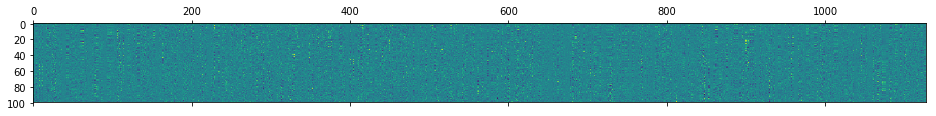

In [33]:
# trying to see the correlation, but it's hard to see.
plt.figure(figsize=(10,10))
plt.matshow(pca_explained)

#### Most important features

In [34]:
most_important=[np.abs(pca.components_[i]).argmax() for i in range(100)]

In [35]:
tags=genomeTags['tag']
new_key=[]

for num in most_important:
      new_key.append(tags[num])

In [36]:
important_tags={'PC{}'.format(i): new_key[i] for i in range(100) }

In [37]:
from collections import Counter
import operator

most_important_count=Counter(new_key)
most_important_count_sort = sorted(most_important_count.items(), key=operator.itemgetter(1), reverse=True)

In [38]:
most_important_count_sort=most_important_count_sort[:20]

Text(0.5, 1.0, '20 Most Popular Tags')

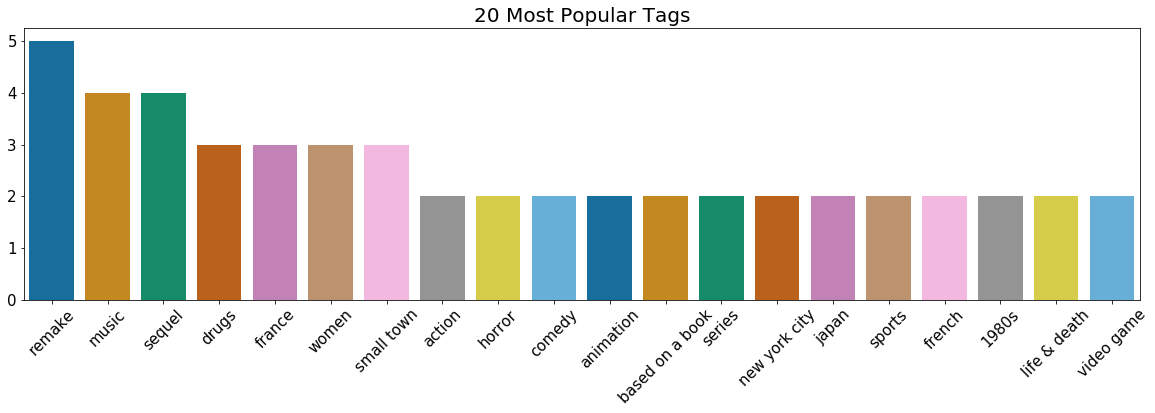

In [39]:
x_ax=[]
y_ax=[]

for i in most_important_count_sort:
    x_ax.append(i[0])
    y_ax.append(i[1])

plt.figure(figsize=(20,5))
sns.barplot(x=x_ax, y=y_ax, palette='colorblind')
plt.xticks(rotation=45)
plt.tick_params(labelsize=15)
plt.title("20 Most Popular Tags", fontsize=20)

In [1]:
# combine the most popular tags with unsuccessful movie tags or small films

###  Merge two feature sets

In [40]:
print(tags_pca.shape)
tags_pca.head(2)

(10381, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.636799,2.121422,2.282099,1.082026,1.294148,-1.081941,1.067232,1.318012,-0.792389,-1.512622,...,0.353763,-0.049455,-0.160273,-0.111615,-0.246597,0.101377,-0.024929,-0.080656,-0.072975,0.035322
1,-1.620003,1.542523,1.146524,0.830368,0.070493,-0.456105,0.088840,1.050016,-0.451456,-0.902905,...,-0.087347,-0.066552,0.080236,0.053926,0.013782,-0.155445,-0.138064,-0.073154,-0.165914,0.042047


In [42]:
print(tag_tb.shape)
tag_tb.tail(2)

(10381, 1128)


tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
131168,0.05975,0.10375,0.1785,0.14875,0.2775,0.1625,0.04125,0.25475,0.06900,0.15375,...,0.203,0.16325,0.81025,0.0190,0.18175,0.03225,0.04800,0.51925,0.0670,0.01725
131170,0.05325,0.08625,0.0170,0.02650,0.1570,0.0935,0.08550,0.34700,0.14175,0.03050,...,0.020,0.02400,0.01500,0.0445,0.64375,0.58775,0.01075,0.01575,0.1145,0.02175


In [41]:
tags_pca['movieId']=tag_tb.index
tags_pca.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,movieId
10371,-1.586950,0.129254,1.113477,0.499842,-0.059697,0.070793,0.444122,0.487037,-0.518899,-0.253255,...,0.025398,-0.106122,0.016678,-0.178264,-0.054627,0.135448,0.079097,0.217746,0.228238,130075
10372,-1.465875,0.169694,0.139030,0.264742,-0.250766,0.226787,0.312373,-0.125901,0.020967,-0.467775,...,-0.054074,-0.034217,0.013147,0.233010,0.079271,-0.080305,0.121258,0.050071,-0.000906,130087
10373,-1.972834,0.438243,0.165151,0.501388,-0.690807,0.678827,-0.337136,-0.287022,0.025819,0.358188,...,0.128827,-0.104747,-0.044767,0.010285,0.135226,-0.147665,-0.073447,-0.194859,-0.087806,130490
10374,-1.338299,0.891886,-0.196205,-0.084368,-0.138287,-0.064247,-0.114304,-0.520262,-0.413173,-0.072436,...,-0.090254,0.208333,0.413865,-0.039152,-0.240551,-0.180792,0.020805,0.150431,0.088462,130496
10375,-1.481921,-0.037420,1.017029,0.628599,0.257747,-0.222387,0.522257,0.518454,-0.293177,-1.167351,...,0.184915,-0.281731,-0.209127,-0.196053,0.096780,0.041318,0.026984,-0.020639,-0.025416,130520
10376,-2.020779,-0.573755,-0.321902,-0.405656,-1.140604,-0.301498,-0.096569,-0.784446,-0.605252,-0.346268,...,0.123053,0.017973,0.038270,-0.014528,-0.122879,-0.045575,-0.153035,-0.156997,-0.094707,130578
10377,0.438845,-0.516363,-0.563928,0.886456,-0.130510,0.961269,-0.000598,1.179328,-0.038895,0.794465,...,0.233444,-0.180781,-0.119856,0.030742,0.004065,-0.170106,-0.067184,-0.243802,-0.113664,130840
10378,-1.693994,-0.095674,-0.213209,-0.719169,1.152155,-0.196490,0.502097,-0.827246,1.152780,0.191408,...,0.104623,-0.083002,0.124596,0.078802,-0.030450,-0.182364,0.116557,0.228906,0.157162,131013
10379,1.835314,-0.217458,0.280566,-0.544066,-1.533384,-0.648774,0.298892,0.222346,0.174835,1.063225,...,-0.006018,-0.202448,-0.017183,0.001934,0.038463,0.094493,0.443270,-0.002296,-0.000453,131168
10380,0.503236,2.115387,-0.455192,1.214367,-0.257783,2.532987,0.448352,0.037637,0.614199,-0.123118,...,-0.278231,0.122250,0.140112,-0.226823,0.036781,0.100602,0.213437,-0.196469,0.318678,131170


In [42]:
movies=pd.merge(movies, tags_pca, on='movieId')

movies = movies.drop('title', axis=1)

**We now have a feature set!**

## Ratings

### See the most popular rated-movies

In [62]:
popular_movies=pd.DataFrame(
    ratings.groupby(by='movieId').count().sort_values('rating', ascending=False)['rating'])

#### Long Tail Plot to see the popularity of the movies rated

In [63]:
popular_movies.reset_index(inplace=True)

In [64]:
popular_movies.head(3)

,movieId,rating
0,296,67310
1,356,66172
2,318,63366


In [65]:
popular_movies['cumulative']=popular_movies.rating.cumsum()

In [66]:
len(popular_movies.loc[popular_movies['cumulative']<(20000263*.8)])

1948

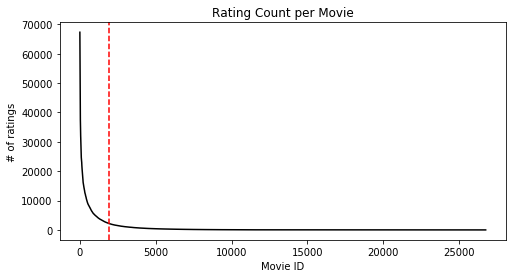

In [151]:
x=range(0,len(popular_movies))

plt.figure(figsize=(8, 4))
ax = sns.lineplot(x, y="rating", data=popular_movies, color="black")

ax.set_title('Rating Count per Movie')
ax.set_ylabel('# of ratings')
ax.set_xlabel('Movie ID')
plt.axvline(x=1948, linestyle='--', color="red")

In [67]:
popular_movies=popular_movies.iloc[:3000]

## Build Models

### Divide Train Set
The ratings have 20 mil rows. To make the training more efficient, I will be dividing the dataset to smaller training sets. 

In [68]:
ratings = pd.read_csv('ratings.csv')

In [69]:
# Filter out movies that are unpopular - we don't wanna recommend unpopular movies!

ratings_df=ratings.loc[ratings.movieId.isin(popular_movies.movieId.unique())]

In [70]:
len(ratings_df.movieId.unique())
#total 3000 unique movies in the recommendation engine

3000

Text(0.5, 1.0, 'Distribution of Ratings for Popular Movies')

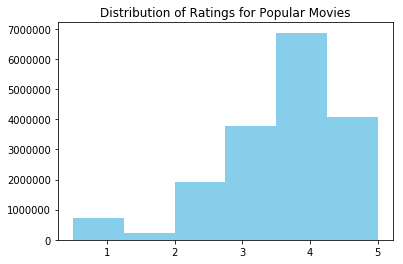

In [72]:
plt.hist(ratings_df["rating"], bins=6, color = "skyblue")
plt.title("Distribution of Ratings for Popular Movies")

In [73]:
# sort ratings table by timestamp so that I can divide it for different iterations.
ratings_df=ratings_df.sort_values("timestamp", ascending=True)

In [74]:
ratings_df=ratings_df.drop('timestamp', axis=1)
ratings_df.reset_index(inplace=True, drop=True)
ratings_df.head()

,userId,movieId,rating
0,28507,1176,4.0
1,131160,1079,3.0
2,131160,47,5.0
3,131160,21,3.0
4,85252,24,3.0


In [56]:
# ratings.iloc[0:10]
chunk_size = int(ratings_df.shape[0] / 100)

In [57]:
range(0, ratings_df.shape[0], chunk_size)

range(0, 17599744, 175997)

In [58]:
dfs= []
for row in range(0, ratings_df.shape[0], chunk_size):
    df_subset = ratings_df.iloc[row:row + chunk_size]
    dfs.append(df_subset)

In [59]:
print(len(dfs[0]))
dfs[0].head()

175997


,userId,movieId,rating
0,28507,1176,4.0
1,131160,1079,3.0
2,131160,47,5.0
3,131160,21,3.0
4,85252,24,3.0


### Nearest Neighbors
#### Using Ratings Only
- First Iteration

In [60]:
from scipy.sparse import csr_matrix

In [61]:
movies_raw = pd.read_csv('movies.csv')

In [62]:
train_1=dfs[0]

In [63]:
# pivot and create movie-user matrix
movie_user_mat = train_1.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# create mapper from movie title to index
movie_to_idx = {
    i: movie for i, movie in 
    enumerate(list(movies_raw.set_index('movieId').loc[movie_user_mat.index].title))
}

# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [64]:
from sklearn.neighbors import NearestNeighbors

# define model
NN_cos = NearestNeighbors(metric='cosine', algorithm='brute')

# fit
NN_cos.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

- Test the engine

In [80]:
query_index=np.random.choice(movie_user_mat.shape[0])
distances, indices = NN_cos.kneighbors(movie_user_mat.iloc[query_index,:].values.reshape(1,-1))

for i in range(0, len(distances.flatten())):
    if i == 0:
        print("People who liked *{0}* also liked:\n".format(movie_to_idx.get(movie_user_mat.index[query_index])))
    else: 
        print('{0}: {1}, with similarity score of {2}'.format(i, movie_to_idx.get(movie_user_mat.index[indices.flatten()[i]]),distances.flatten()[i]))

People who liked *Misérables, Les (1995)* also liked:

1: Ed Wood (1994), with similarity score of 0.6082635908182086
2: Menace II Society (1993), with similarity score of 0.6315810626988685
3: Indian in the Cupboard, The (1995), with similarity score of 0.6329531255620646
4: Boxing Helena (1993), with similarity score of 0.6590087675832442


In [81]:
distances.flatten()

array([0.        , 0.60826359, 0.63158106, 0.63295313, 0.65900877])

In [82]:
movie_to_idx.get(2)
movie_to_idx.get(movie_user_mat.index[indices.flatten()[2]]),distances.flatten()[2]

('Menace II Society (1993)', 0.6315810626988685)

#### Evaluation I

For n_clusters = 3 The average silhouette_score is : 0.3706924758536127
For n_clusters = 4 The average silhouette_score is : 0.3431701042573199
For n_clusters = 5 The average silhouette_score is : 0.32491394348499375
For n_clusters = 7 The average silhouette_score is : 0.3673961546013058
For n_clusters = 9 The average silhouette_score is : 0.26443981621798907


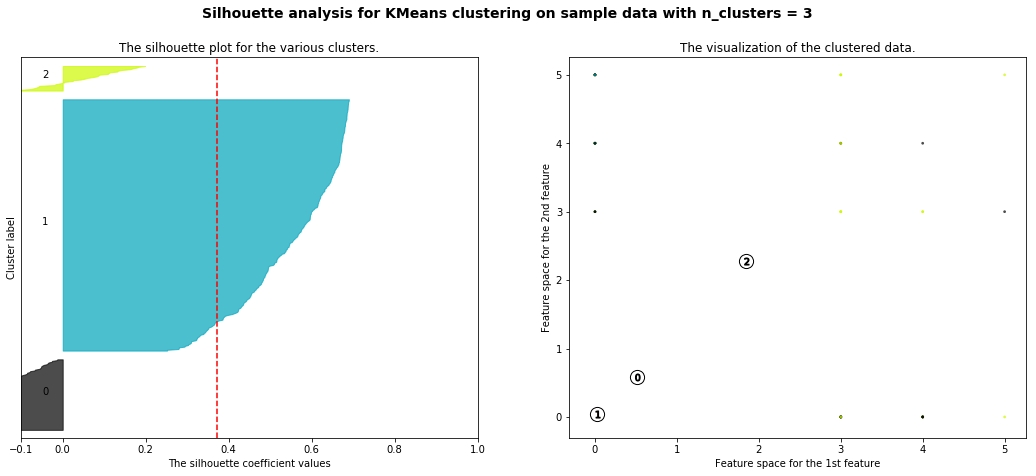

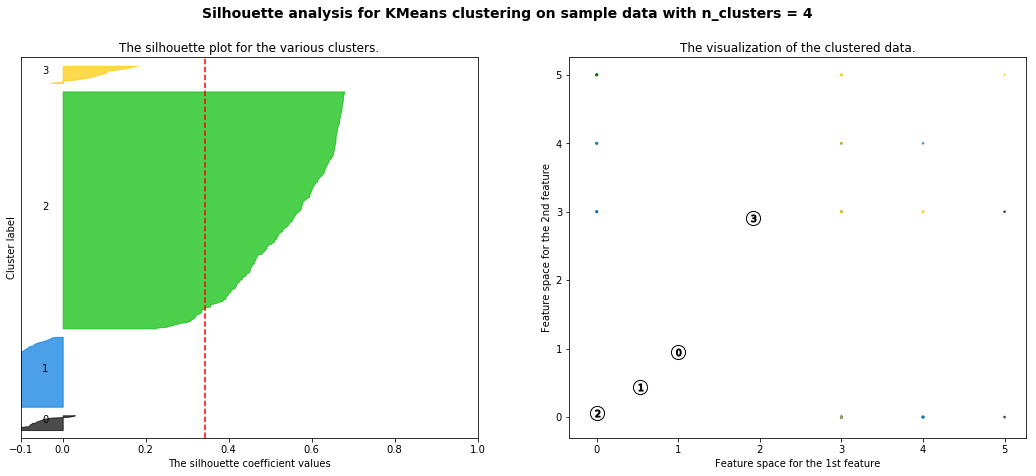

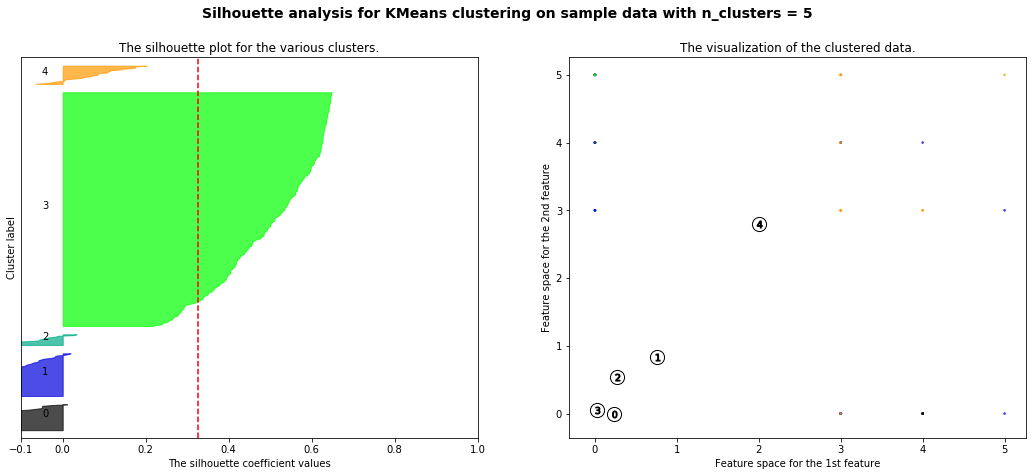

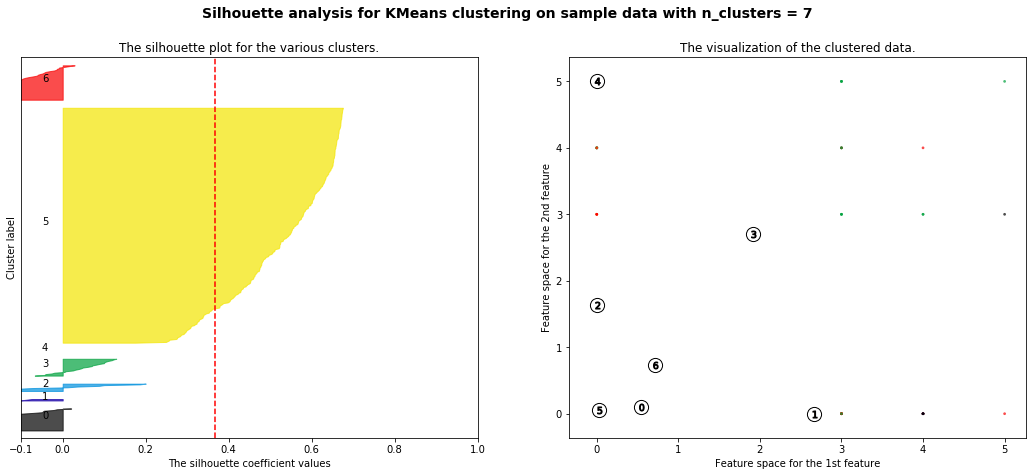

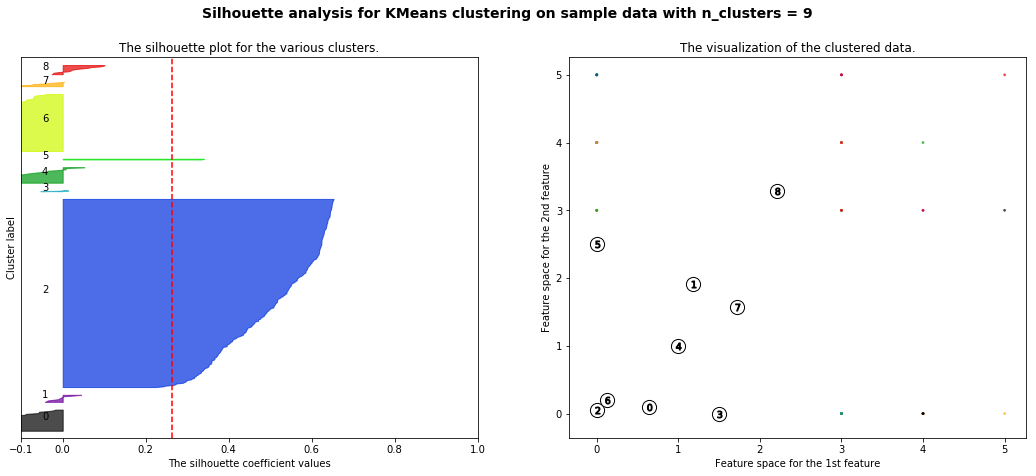

In [210]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [3, 4, 5, 7, 9]
X=movie_user_mat

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

#### Content-based

In [83]:
movie_feature_mat = movies.iloc[:,2:]

movie_feature_to_idx = {
    i: movie for i, movie in 
    enumerate(list(movies_raw.set_index('movieId').loc[movies.movieId].title))
}

movie_feature_mat_sparse = csr_matrix(movie_feature_mat.values)

# define model
NN_cos_feature = NearestNeighbors(metric='cosine', algorithm='brute')

# fit
NN_cos_feature.fit(movie_feature_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [99]:
# change it to cosine similarity 
query_index=np.random.choice(movie_feature_mat.shape[0])
distances, indices = NN_cos_feature.kneighbors(movie_feature_mat.iloc[query_index,:].values.reshape(1,-1))

for i in range(0, len(distances.flatten())):
    if i == 0:
        print("If you liked *{0}*, you might also like:\n".format(movie_feature_to_idx.get(movie_feature_mat.index[query_index])))
    else: 
        print('{0}: {1}, with similarity score of {2}'.format(i, movie_feature_to_idx.get(movie_feature_mat.index[indices.flatten()[i]]),distances.flatten()[i]))

If you liked *Stepfather II (1989)*, you might also like:

1: Child's Play 2 (1990), with similarity score of 0.11632292724744109
2: Psycho III (1986), with similarity score of 0.11733792119260478
3: Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995), with similarity score of 0.1245249073680077
4: Children of the Corn IV: The Gathering (1996), with similarity score of 0.15550727274309284


In [100]:
movie_feature_to_idx.get(movie_feature_mat.index[1])
print('{0}, with distance of {1}'.format(movie_feature_to_idx.get(movie_feature_mat.index[indices.flatten()[1]]),distances.flatten()[1]))

Child's Play 2 (1990), with distance of 0.11632292724744109


#### Evaluation II

For n_clusters = 3 The average silhouette_score is : 0.07410225432406302
For n_clusters = 4 The average silhouette_score is : 0.06445806171589429
For n_clusters = 5 The average silhouette_score is : 0.07494724305163554
For n_clusters = 7 The average silhouette_score is : 0.06397409050457016
For n_clusters = 9 The average silhouette_score is : 0.06999511555497398


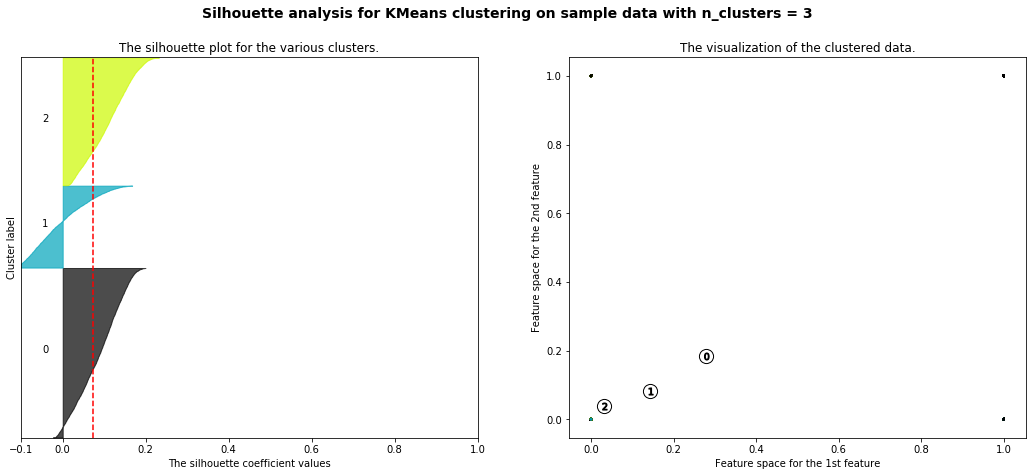

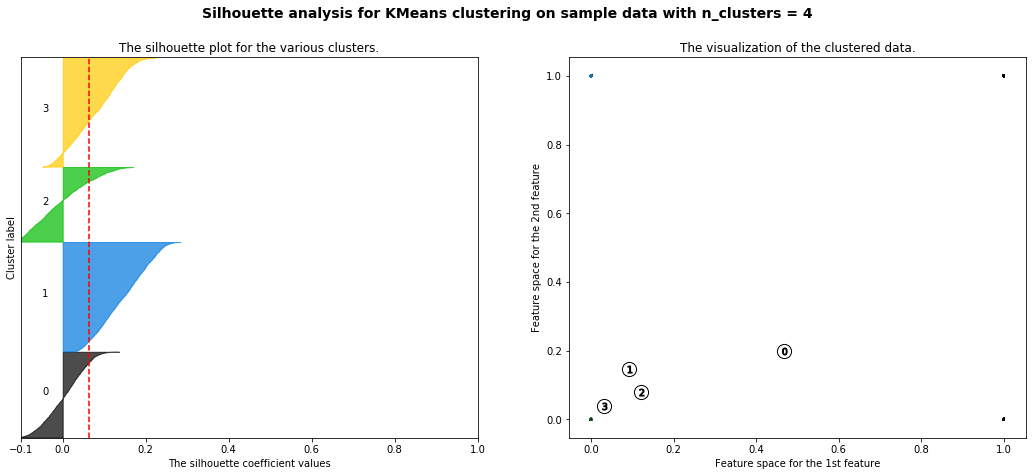

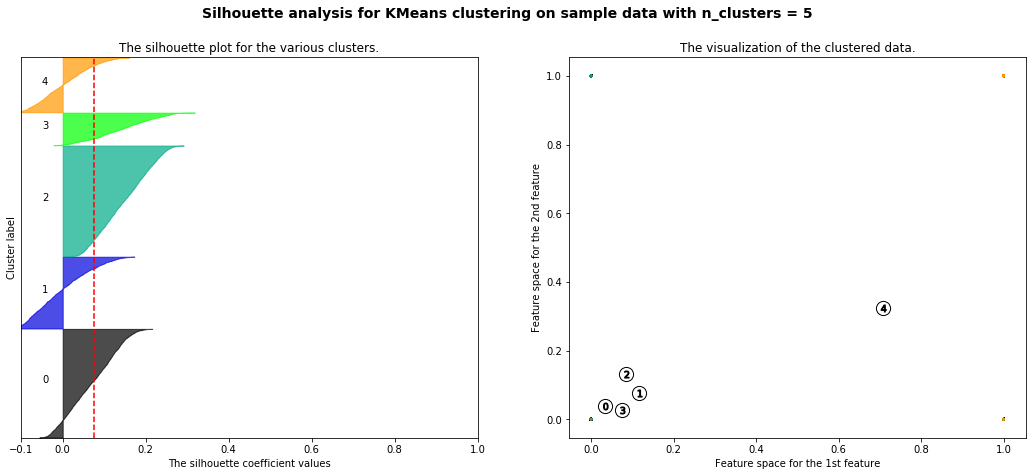

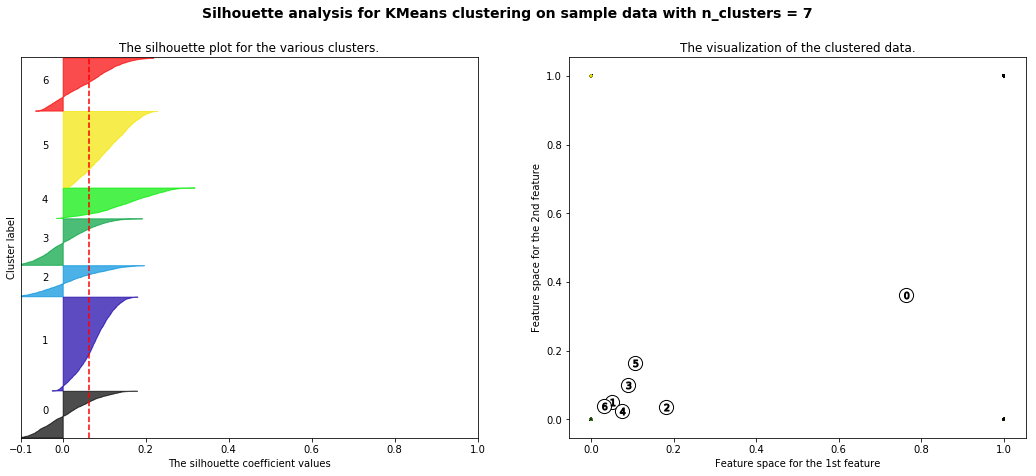

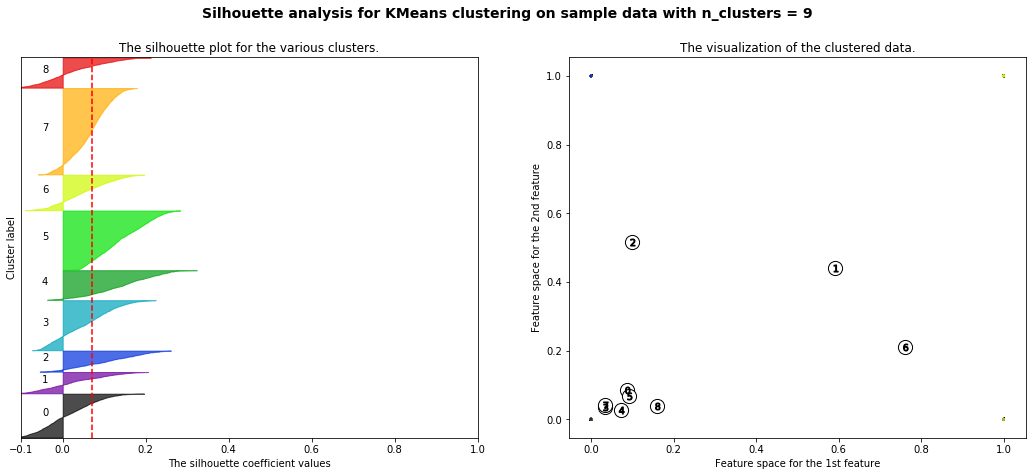

In [213]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [3, 4, 5, 7, 9]
X=movie_feature_mat

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.values[:, 0], X.values[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

### Keras

#### Using Ratings

In [169]:
keras_train=dfs[0]
keras_train.shape

(175997, 3)

In [170]:
keras_train.groupby(by='userId')['rating'].count().sort_values(ascending=False).head(10)

userId
133330    318
45721     311
10651     300
27157     272
52054     248
65737     212
330       203
83510     201
136362    193
106883    180
Name: rating, dtype: int64

In [200]:
keras_train.head()

,userId,movieId,rating
0,779,439,4.0
1,3593,438,3.0
2,3593,42,5.0
3,3593,20,3.0
4,2309,23,3.0


In [171]:
keras_train['userId']= keras_train['userId'].astype('category').cat.codes.values
keras_train.movieId = keras_train.movieId.astype('category').cat.codes.values

n_users = len(keras_train.userId.unique())
n_movies = len(keras_train.movieId.unique())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


##### Embedding Method with loss as MSE

In [172]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, 6, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, 6, name='User-Embedding')(user_input))

prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.


In [173]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 6)         2646        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 6)         22794       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [174]:
history = model.fit([keras_train.userId, keras_train.movieId], keras_train.rating, epochs=5, verbose=0)

Instructions for updating:
Use tf.cast instead.


Text(0, 0.5, 'Train Error')

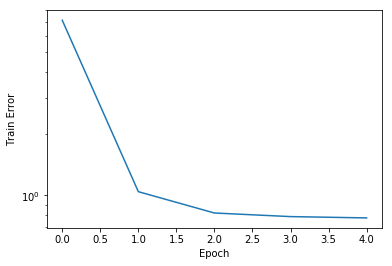

In [175]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [182]:
y_hat = np.round(model.predict([keras_train.userId, keras_train.movieId]),0)
y_true = keras_train.rating

In [183]:
print("MAE for Keras I:\n", mean_absolute_error(y_true, y_hat))
print("\nRMSE for Keras I:\n",mean_squared_error(y_true, y_hat))

MAE for Keras I:
 0.6198060194207856

RMSE for Keras I:
 0.8257186202037535


In [186]:
movie_embedding.shape

TensorShape([Dimension(None), Dimension(1), Dimension(6)])

In [188]:
keras_train.head(3)

,userId,movieId,rating
0,779,439,4.0
1,3593,438,3.0
2,3593,42,5.0


In [203]:
pd.merge(keras_train, tags_pca, on='movieId').head()

,userId,movieId,rating,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,779,439,4.0,-1.695000,-0.710136,-0.304899,-0.253855,-0.395847,0.454213,-0.447654,...,-0.049954,0.028675,0.082979,-0.258492,-0.101622,-0.041439,0.132714,0.121986,0.045699,0.006553
1,3593,438,3.0,-1.515365,0.126889,0.229816,-0.486530,0.434564,-0.066199,0.023190,...,-0.169314,-0.018118,0.219043,-0.079157,-0.136534,0.099782,0.011402,-0.059163,-0.155068,-0.032538
2,3593,42,5.0,0.145001,0.197085,-0.737844,-1.153895,0.245390,-0.261671,-1.250918,...,-0.201122,-0.078342,0.184842,-0.009049,-0.055049,-0.020833,0.054223,0.112207,-0.171785,0.025373
3,2708,42,5.0,0.145001,0.197085,-0.737844,-1.153895,0.245390,-0.261671,-1.250918,...,-0.201122,-0.078342,0.184842,-0.009049,-0.055049,-0.020833,0.054223,0.112207,-0.171785,0.025373
4,3388,42,5.0,0.145001,0.197085,-0.737844,-1.153895,0.245390,-0.261671,-1.250918,...,-0.201122,-0.078342,0.184842,-0.009049,-0.055049,-0.020833,0.054223,0.112207,-0.171785,0.025373


*I first built the Keras model below, but my kernel kept dying. I moved on to building another one shown above.*

In [71]:
keras_pivot=keras_train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [72]:
keras_pivot.shape

(6697, 447)

In [73]:
keras_pivot.sum().sort_values(ascending=False).tail(5)

movieId
1176    4.0
1079    3.0
518     3.0
504     1.0
436     1.0
dtype: float64

In [74]:
keras_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,748,750,761,765,766,778,781,784,1079,1176
userId,,,,,,,,,,,,,,,,,,,,,
8,4.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
X = keras_pivot.iloc[:,:keras_pivot.shape[1]-1]
Y = keras_pivot.iloc[:,keras_pivot.shape[1]-1:]

In [134]:
X.shape

(6697, 408)

In [135]:
Y.shape

(6697, 1)

In [136]:
(x_train, x_test)=X[(int)(X.shape[0]*0.3):],X[:(int)(X.shape[0]*0.3)]
(y_train,y_test)=Y[(int)(Y.shape[0]*0.3):],Y[:(int)(Y.shape[0]*0.3)]

In [137]:
y_train=keras.utils.to_categorical(y_train,6)
y_test=keras.utils.to_categorical(y_test,6)

In [138]:
print(y_train.shape)
print(x_train.shape)

(4688, 6)
(4688, 408)


In [139]:
# Start with a simple sequential model
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(408,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(6, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                26176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
___________________________

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 4688 samples, validate on 2009 samples
Epoch 1/10


# Final evaluation: Add Mean absolute error


In [70]:
from sklearn.metrics import mean_absolute_error

test_performance = mean_absolute_error(test["rating"], predictions)


from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))
## Output
User-based CF RMSE: 699.9584792778463
Item-based CF RMSE: 114.97271725933925

### Using pandas

In [ ]:
# Research Matrix factorization
# Look into building Keras and class
# Narrow down to predicting for one user? 

# Future: ALS, recmetrics, etc